# Реализация [StarGAN v2](https://arxiv.org/pdf/1912.01865.pdf)

In [1]:
# Для работы в колабе раскоменьте эти строки
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
%cd DeepGenerativeModels/

Cloning into 'DeepGenerativeModels'...
remote: Enumerating objects: 630, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 630 (delta 74), reused 147 (delta 52), pack-reused 447
Receiving objects: 100% (630/630), 173.21 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (254/254), done.
/content/DeepGenerativeModels


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%time
!mkdir -p data/celeba
!cp ../drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/GAN/second/list_attr_celeba.txt data/celeba/list_attr_celeba.txt
!cp ../drive/MyDrive/Colab\ Notebooks/YSDA\ Sem\ 4/GAN/second/img_align_celeba.zip data/celeba/img_align_celeba.zip
!unzip -q data/celeba/img_align_celeba.zip -d data/celeba
!mkdir checkpoints

CPU times: user 275 ms, sys: 68.9 ms, total: 344 ms
Wall time: 44 s


# Этап 1. Загрузка данных
В данном задании вам предстоит работать с уже знакомым датасетом с лицами и генерировать новые лица с заданными аттрибутами

In [4]:
!pip install -q git+https://github.com/S-aiueo32/lpips-pytorch.git
!pip install -q munch

  Preparing metadata (setup.py) ... done
  Running setup.py install for lpips-pytorch ... done
  DEPRECATION: lpips-pytorch was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [5]:
import sys; sys.path.append('utils/')
from datasets.celeba import CelebADataset

import os
import gc
import re
import time
import math
import random
import shutil
import numpy as np
from munch import Munch
from natsort import natsorted
from tqdm import tqdm
from tqdm.auto import trange
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from lpips_pytorch import LPIPS
from torchvision import transforms

In [6]:
## Setup
# Number of gpus available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Munch() # dictionary with attribute-style access

# Spatial size of training images, images are resized to this size.
args.img_size = 128 # in paper = 256

# Transformations to be applied to each individual image sample
transform = transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

# Load the dataset from file and apply transformations
dataset = CelebADataset(transform=transform)
print(f"Total images: {len(os.listdir('data/celeba/img_align_celeba'))}")

args.num_domains = 2 # Задайте число доменов (Male/Female, StarGAN v2)
args.batch_size = 8

# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2

# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=args.batch_size,
                                         num_workers=num_workers,
                                         pin_memory=pin_memory,
                                         shuffle=True)

Total images: 202599


## Визуализация датасетов

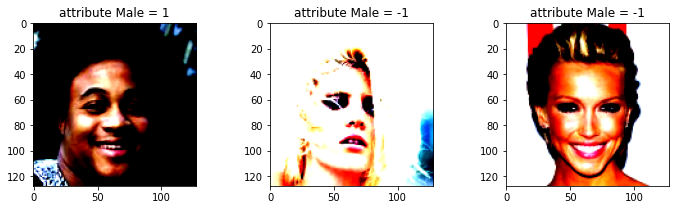

In [7]:
images_cnt = 3
plt.figure(figsize=(images_cnt*4, 3))

for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(1, images_cnt, i+1)
    img = np.clip(img.detach().cpu().numpy().transpose(1,2,0), 0, 1)
    plt.imshow(img)
    plt.title(f"attribute Male = {attributes['Male']}")

## Создание датасета для StarGAN V2

In [8]:
class CelebADatasetStarGANV2(Dataset):
    def __init__(self, 
                 dataset_folder='data/celeba/img_align_celeba/',
                 annotation_file='data/celeba/list_attr_celeba.txt',
                 latent_dim=16,
                 transform=None):
        self.dataset_folder = dataset_folder
        self.annotation_file = annotation_file
        self.latent_dim = latent_dim
        self.transform = transform
        self.sex_annotation = {}

        with open(annotation_file) as f:
            for i, line in enumerate(f.readlines()):
                line = re.sub(' *\n', '', line)
                if i == 0:
                    header = re.split(' +', line)
                    sex_index = header.index('Male')
                else:
                    values = re.split(' +', line)
                    filename = values[0]
                    sex = {-1: 0, 1: 1}[int(values[1:][sex_index])]
                    self.sex_annotation[filename] = sex

        # two sexes, keep equal parts
        male_images = [k for k, v in self.sex_annotation.items() if v == 1]
        female_images = [k for k, v in self.sex_annotation.items() if v == 0]
        size = min(len(male_images), len(female_images))
        male_images = male_images[:size]
        female_images = female_images[:size]

        # for male pick random 2 reference females and vice versa
        x_srcs = male_images + female_images
        y_srcs = [1] * size + [0] * size
        x_refs = random.sample(female_images, size) + random.sample(male_images, size)
        x_refs2 = random.sample(female_images, size) + random.sample(male_images, size)
        y_refs = [0] * size + [1] * size
        
        # dataset of samples
        self.samples = list(zip(x_srcs, y_srcs, x_refs, x_refs2, y_refs))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x_src, y_src, x_ref, x_ref2, y_ref = self.samples[idx]
        x_src_img = Image.open(os.path.join(self.dataset_folder, x_src)).convert('RGB')
        x_ref_img = Image.open(os.path.join(self.dataset_folder, x_ref)).convert('RGB')
        x_ref2_img = Image.open(os.path.join(self.dataset_folder, x_ref2)).convert('RGB')

        if self.transform:
            x_src_img = self.transform(x_src_img)
            x_ref_img = self.transform(x_ref_img)
            x_ref2_img = self.transform(x_ref2_img)
          
        z_trg = torch.randn(self.latent_dim)
        z_trg2 = torch.randn(self.latent_dim)

        return x_src_img, y_src, x_ref_img, x_ref2_img, y_ref, z_trg, z_trg2

x_src ~ torch.Size([3, 128, 128])
x_ref_img ~ torch.Size([3, 128, 128])
x_ref2_img ~ torch.Size([3, 128, 128])
z_trg ~ torch.Size([16])
z_trg2 ~ torch.Size([16])

Source and two references:


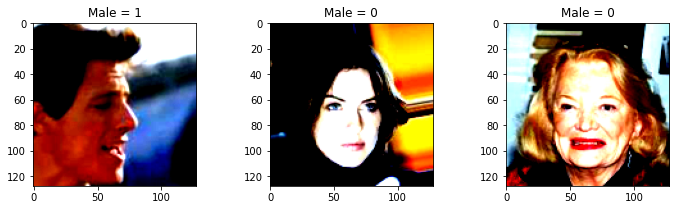

In [9]:
ds = CelebADatasetStarGANV2(transform=transform)
x_src_img, y_src, x_ref_img, x_ref2_img, y_ref, z_trg, z_trg2 = ds[0]
print(f'x_src ~ {x_src_img.shape}')
print(f'x_ref_img ~ {x_ref_img.shape}')
print(f'x_ref2_img ~ {x_ref2_img.shape}')
print(f'z_trg ~ {z_trg.shape}')
print(f'z_trg2 ~ {z_trg2.shape}')

print('\nSource and two references:')

plt.figure(figsize=(12, 3))
for i, (img, label) in enumerate(zip([x_src_img, x_ref_img, x_ref2_img], 
                                     [y_src, y_ref, y_ref])):
    plt.subplot(1, 3, i+1)
    img = np.clip(img.detach().cpu().numpy().transpose(1,2,0), 0, 1)
    plt.imshow(img)
    plt.title(f"Male = {label}")

# Этап 2. Обучение модели
В рамках данного задания предлагается реализовать и обучить StarGAN для генережки лиц с заданными аттрибутами
![](assets/stargan.png)

Вам на выбор предлагается реализовать [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**) или [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

## Модули

In [10]:
class ResBlk(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 actv=nn.LeakyReLU(0.2),
                 normalize=False, 
                 downsample=False):
        super().__init__()
        self.normalize = normalize
        self.downsample = downsample
        self.actv = actv
        self.diff_channels = in_channels != out_channels
        self._build_weights(in_channels, out_channels)

    def _build_weights(self, in_channels, out_channels):
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        if self.normalize:
            self.norm1 = nn.InstanceNorm2d(in_channels, affine=True)
            self.norm2 = nn.InstanceNorm2d(in_channels, affine=True)
        if self.diff_channels:
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.diff_channels:
            x = self.conv1x1(x)
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        return x

    def _residual(self, x):
        if self.normalize:
            x = self.norm1(x)
        x = self.conv1(self.actv(x))
        if self.downsample:
            x = F.avg_pool2d(x, 2)
        if self.normalize:
            x = self.norm2(x)
        x = self.conv2(self.actv(x))
        return x

    def forward(self, x):
        return (self._shortcut(x) + self._residual(x)) / math.sqrt(2)

class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta

class AdainResBlk(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 style_dim=64,
                 actv=nn.LeakyReLU(0.2), 
                 upsample=False):
        super().__init__()
        self.actv = actv
        self.upsample = upsample
        self.diff_channels = in_channels != out_channels
        self._build_weights(in_channels, out_channels, style_dim)

    def _build_weights(self, in_channels, out_channels, style_dim=16):
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.norm1 = AdaIN(style_dim, in_channels)
        self.norm2 = AdaIN(style_dim, out_channels)
        if self.diff_channels:
            self.conv1x1 = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False)

    def _shortcut(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        if self.diff_channels:
            x = self.conv1x1(x)
        return x

    def _residual(self, x, s):
        x = self.actv(self.norm1(x, s))
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = self.norm2(self.conv1(x), s)
        x = self.conv2(self.actv(x))
        return x

    def forward(self, x, s):
        return (self._residual(x, s) + self._shortcut(x)) / math.sqrt(2)

In [11]:
class Generator(nn.Module):
    def __init__(self, 
                 style_dim=64):
        super().__init__()
        self.from_rgb = nn.Conv2d(3, 128, 3, 1, 1)
        self.encode = nn.ModuleList([
            ResBlk(128, 256, normalize=True, downsample=True),
            ResBlk(256, 512, normalize=True, downsample=True),
            ResBlk(512, 512, normalize=True, downsample=True),
            ResBlk(512, 512, normalize=True),
            ResBlk(512, 512, normalize=True),
        ])
        self.decode = nn.ModuleList([
            AdainResBlk(512, 512, style_dim),
            AdainResBlk(512, 512, style_dim),
            AdainResBlk(512, 512, style_dim, upsample=True),
            AdainResBlk(512, 256, style_dim, upsample=True),
            AdainResBlk(256, 128, style_dim, upsample=True),
        ])
        self.to_rgb = nn.Sequential(
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 3, 1, 1, 0))

    def forward(self, x, s):
        x = self.from_rgb(x)
        cache = {}
        for block in self.encode:
            x = block(x)
        for block in self.decode:
            x = block(x, s)
        return self.to_rgb(x)

class MappingNetwork(nn.Module):
    def __init__(self, 
                 latent_dim=16, 
                 style_dim=64, 
                 num_domains=2):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(latent_dim, 512), 
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Sequential(nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, 512),
                                            nn.ReLU(),
                                            nn.Linear(512, style_dim))]

    def forward(self, z, y):
        h = self.shared(z)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        return out[idx, y]

class StyleEncoder(nn.Module):
    def __init__(self,
                 style_dim=64, 
                 num_domains=2):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),
            ResBlk(128, 256, downsample=True),
            ResBlk(256, 512, downsample=True),
            ResBlk(512, 512, downsample=True),
            ResBlk(512, 512, downsample=True),
            ResBlk(512, 512, downsample=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 4, 1, 0),
            nn.LeakyReLU(0.2),
        )
        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Linear(512, style_dim)]

    def forward(self, x, y):
        h = self.shared(x)
        h = h.view(h.size(0), -1)
        out = []
        for layer in self.unshared:
            out += [layer(h)]
        out = torch.stack(out, dim=1)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        return out[idx, y]

class Discriminator(nn.Module):
    def __init__(self, 
                 num_domains=2):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 3, 1, 1),
            ResBlk(128, 256, downsample=True),
            ResBlk(256, 512, downsample=True),
            ResBlk(512, 512, downsample=True),
            ResBlk(512, 512, downsample=True),
            ResBlk(512, 512, downsample=True),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, num_domains, 1, 1, 0)
        )

    def forward(self, x, y):
        out = self.main(x)
        out = out.view(out.size(0), -1)
        idx = torch.LongTensor(range(y.size(0))).to(y.device)
        return out[idx, y]

## Лоссы

In [12]:
def adv_loss(logits, target):
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss

def r1_reg(d_out, x_in):
    batch_size = x_in.size(0)
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), 
        inputs=x_in,
        create_graph=True, 
        retain_graph=True, 
        only_inputs=True
    )
    grad_dout2 = grad_dout[0].pow(2)
    reg = 0.5 * grad_dout2.view(batch_size, -1).sum(1).mean(0)
    return reg

def compute_d_loss(nets, args, x_real, y_org, y_trg, z_trg=None, x_ref=None):
    # real loss & regularization
    x_real.requires_grad_()
    out = nets.discriminator(x_real, y_org)
    loss_real = adv_loss(out, 1)
    loss_reg = r1_reg(out, x_real)

    # fake loss
    with torch.no_grad():
        if z_trg is not None:
            s_trg = nets.mapping_network(z_trg, y_trg)
        if x_ref is not None:
            s_trg = nets.style_encoder(x_ref, y_trg)
        x_fake = nets.generator(x_real, s_trg)
    out = nets.discriminator(x_fake, y_trg)
    loss_fake = adv_loss(out, 0)

    # total loss
    loss = loss_real + \
           loss_fake + \
           args.lambda_reg * loss_reg
    return loss, Munch(real=loss_real.item(),
                       fake=loss_fake.item(),
                       reg=loss_reg.item())

def compute_g_loss(nets, args, x_real, y_org, y_trg, z_trgs=None, x_refs=None):
    # style from latents
    if z_trgs is not None:
        z_trg, z_trg2 = z_trgs
        s_trg = nets.mapping_network(z_trg, y_trg)
        s_trg2 = nets.mapping_network(z_trg2, y_trg)

    # style from references
    if x_refs is not None:
        x_ref, x_ref2 = x_refs
        s_trg = nets.style_encoder(x_ref, y_trg)
        s_trg2 = nets.style_encoder(x_ref2, y_trg)

    # adversarial loss
    x_fake = nets.generator(x_real, s_trg)
    out = nets.discriminator(x_fake, y_trg)
    loss_adv = adv_loss(out, 1)

    # style reconstruction loss
    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = torch.mean(torch.abs(s_pred - s_trg))

    # diversity sensitive loss
    x_fake2 = nets.generator(x_real, s_trg2)
    x_fake2 = x_fake2.detach()
    loss_ds = torch.mean(torch.abs(x_fake - x_fake2))

    # cycle-consistency loss
    s_org = nets.style_encoder(x_real, y_org)
    x_rec = nets.generator(x_fake, s_org)
    loss_cyc = torch.mean(torch.abs(x_rec - x_real))

    # full objective
    loss = loss_adv + \
           args.lambda_sty * loss_sty - \
           args.lambda_ds * loss_ds + \
           args.lambda_cyc * loss_cyc
    return loss, Munch(adv=loss_adv.item(),
                       sty=loss_sty.item(),
                       ds=loss_ds.item(),
                       cyc=loss_cyc.item())

## Обучение

In [15]:
nets = Munch()
nets.generator = Generator().to(device)
nets.mapping_network = MappingNetwork(num_domains=2).to(device)
nets.style_encoder = StyleEncoder(num_domains=2).to(device)
nets.discriminator = Discriminator(num_domains=2).to(device)

defaults = {
    'betas': (0., 0.99),
    'weight_decay': 1e-4,
}

optims = Munch()
optims.generator = torch.optim.Adam(nets.generator.parameters(), lr=1e-4, **defaults)
optims.mapping_network = torch.optim.Adam(nets.mapping_network.parameters(), lr=1e-6, **defaults)
optims.style_encoder = torch.optim.Adam(nets.style_encoder.parameters(), lr=1e-4, **defaults)
optims.discriminator = torch.optim.Adam(nets.discriminator.parameters(), lr=1e-4, **defaults)

def reset_grad(optims):
    for optim in optims.values():
        optim.zero_grad()

def denormalize(x):
    out = (x + 1) / 2
    return np.clip(out, 0, 1)

# He Initialization (Kaiming Initialization)
def he_init(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

for _, module in nets.items():
    for _, network in module.named_children():
        network.apply(he_init)

# dataset
dataset = CelebADatasetStarGANV2(transform=transform)
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=8,
                                         num_workers=2,
                                         pin_memory=False,
                                         shuffle=True)
# parameters
args.lambda_ds = 1.
args.lambda_reg = 1.
args.lambda_cyc = 1.
args.lambda_sty = 1.
args.lambda_reg = 1.

In [23]:
# load partially trained weights (after Colab restart)
last_ckpt = 3000
died_at_step = 3105
root = "../drive/MyDrive/Colab Notebooks/YSDA Sem 4/GAN/second/checkpoints"
nets.generator.load_state_dict(torch.load(f"{root}/generator_{last_ckpt}.ckpt", map_location=torch.device(device)))
nets.mapping_network.load_state_dict(torch.load(f"{root}/mapping_network_{last_ckpt}.ckpt", map_location=torch.device(device)))
nets.style_encoder.load_state_dict(torch.load(f"{root}/style_encoder_{last_ckpt}.ckpt", map_location=torch.device(device)))
nets.discriminator.load_state_dict(torch.load(f"{root}/discriminator_{last_ckpt}.ckpt", map_location=torch.device(device)))

<All keys matched successfully>

In [24]:
n_iters = 6_000
initial_lambda_ds = 1.0

# reduce lambda_ds according to number of steps from previous run
for i in range(died_at_step):
    args.lambda_ds -= (initial_lambda_ds / n_iters)

losses = Munch()
losses.d_latent = []
losses.d_ref = []
losses.g_latent = []
losses.g_ref = []

In [26]:
with tqdm(total=n_iters-died_at_step, desc=f"[lambda_ds: ?]") as pbar:
    for i, (x_real, y_org, 
            x_ref, x_ref2, y_trg, 
            z_trg, z_trg2) in enumerate(dataloader):

        i += died_at_step

        x_real = x_real.to(device)
        y_org = y_org.to(device)
        x_ref = x_ref.to(device)
        x_ref2 = x_ref2.to(device)
        y_trg = y_trg.to(device)
        z_trg = z_trg.to(device)
        z_trg2 = z_trg2.to(device)

        # train the discriminator
        d_loss, d_losses_latent = compute_d_loss(nets, args, x_real, y_org, y_trg, z_trg=z_trg)
        reset_grad(optims)
        d_loss.backward()
        optims.discriminator.step()

        d_loss, d_losses_ref = compute_d_loss(nets, args, x_real, y_org, y_trg, x_ref=x_ref)
        reset_grad(optims)
        d_loss.backward()
        optims.discriminator.step()

        # train the generator/mapping network/style encoder
        g_loss, g_losses_latent = compute_g_loss(nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2])
        reset_grad(optims)
        g_loss.backward()
        optims.generator.step()
        optims.mapping_network.step()
        optims.style_encoder.step()

        g_loss, g_losses_ref = compute_g_loss(nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2])
        reset_grad(optims)
        g_loss.backward()
        optims.generator.step()

        # decay weight for diversity sensitive loss
        if args.lambda_ds > 0:
            args.lambda_ds -= (initial_lambda_ds / n_iters)

        # save losses
        losses.d_latent.append(d_losses_latent)
        losses.d_ref.append(d_losses_ref)
        losses.g_latent.append(g_losses_latent)
        losses.g_ref.append(g_losses_ref)

        # plot losses
        if ((i+1) == 10) or ((i+1) % 500 == 0):
            # clear_output()
            plt.figure(figsize=(25, 6))
            plt.subplot(1, 4, 1)
            plt.plot([x.real for x in losses.d_latent], label='D/latent_real')
            plt.plot([x.fake for x in losses.d_latent], label='D/latent_fake')
            plt.plot([x.reg for x in losses.d_latent], label='D/latent_reg')
            plt.legend()
            plt.subplot(1, 4, 2)
            plt.plot([x.real for x in losses.d_ref], label='D/ref_real')
            plt.plot([x.fake for x in losses.d_ref], label='D/ref_fake')
            plt.plot([x.reg for x in losses.d_ref], label='D/ref_reg')
            plt.legend()
            plt.subplot(1, 4, 3)
            plt.plot([x.adv for x in losses.g_latent], label='G/latent_adv')
            plt.plot([x.sty for x in losses.g_latent], label='G/latent_sty')
            plt.plot([x.ds for x in losses.g_latent], label='G/latent_ds')
            plt.plot([x.cyc for x in losses.g_latent], label='G/latent_cyc')
            plt.legend()
            plt.subplot(1, 4, 4)
            plt.plot([x.adv for x in losses.g_ref], label='G/ref_adv')
            plt.plot([x.sty for x in losses.g_ref], label='G/ref_sty')
            plt.plot([x.ds for x in losses.g_ref], label='G/ref_ds')
            plt.plot([x.cyc for x in losses.g_ref], label='G/ref_cyc')
            plt.legend()
            plt.show()

        # print images
        if ((i+1) == 10) or ((i+1) % 500 == 0):
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            img = denormalize(x_real[0].detach().cpu().numpy().transpose(1,2,0))
            plt.imshow(img)
            plt.title(f'x_real, {y_org[0].item()}')

            plt.subplot(1, 3, 2)
            img = denormalize(x_ref[0].detach().cpu().numpy().transpose(1,2,0))
            plt.imshow(img)
            plt.title(f'x_ref, {y_trg[0].item()}')

            plt.subplot(1, 3, 3)
            x_fake = nets.generator(x_real, nets.style_encoder(x_ref, y_trg))
            img = denormalize(x_fake[0].detach().cpu().numpy().transpose(1,2,0))
            plt.imshow(img)
            plt.title(f'x_fake, {y_trg[0].item()}')
            plt.show()

        # save model checkpoints
        if ((i+1) == 10) or ((i+1) % 1000 == 0):
            for model, path in zip([nets.generator, 
                                    nets.mapping_network, 
                                    nets.style_encoder, 
                                    nets.discriminator], 
                                   [f"checkpoints/generator_{i+1}.ckpt", 
                                    f"checkpoints/mapping_network_{i+1}.ckpt", 
                                    f"checkpoints/style_encoder_{i+1}.ckpt", 
                                    f"checkpoints/discriminator_{i+1}.ckpt"]):
                torch.save(model.state_dict(), path)
                shutil.copy(path, f"../drive/MyDrive/Colab Notebooks/YSDA Sem 4/GAN/second/{path}")

        pbar.set_description(f"[lambda_ds: {args.lambda_ds:.4f}]")
        pbar.update(1)
        if (i+1) == n_iters:
            break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# !rm checkpoints/*

## Evaluation

In [27]:
# Learned Perceptual Image Patch Similarity
lpips = LPIPS()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /root/.cache/torch/hub/checkpoints/alex.pth


  0%|          | 0.00/5.87k [00:00<?, ?B/s]

In [35]:
test_iters = 100
values = []

for i in trange(test_iters):
    # fetch images and labels
    x_real, y_org, x_ref, x_ref2, y_trg, z_trg, z_trg2 = next(iter(dataloader))
    batch_size = x_real.shape[0]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # ваш домен
    
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    x_fake = nets.generator(x_real, nets.style_encoder(x_ref, y_trg)) # YOUR CODE IS HERE

    values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())

assert(np.mean(values) < 1.3), f'Too high, it equals {np.mean(values):.2f}!'
print(f'Good - {np.mean(values):.2f}!')

  0%|          | 0/100 [00:00<?, ?it/s]

AssertionError: ignored

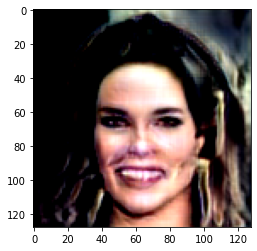

In [41]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, 16)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
#     s_trg = nets.style_encoder(x_ref2, y_trg)
    x_fake = nets.generator(x_real, s_trg)

fake_img = denormalize(x_fake[1].permute(1,2,0).detach().cpu().numpy())
plt.imshow(fake_img)
plt.show()

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**

In [16]:
# load trained weights
last_ckpt = 6000
root = "../drive/MyDrive/Colab Notebooks/YSDA Sem 4/GAN/second/checkpoints"
nets.generator.load_state_dict(torch.load(f"{root}/generator_{last_ckpt}.ckpt", map_location=torch.device(device)))
nets.mapping_network.load_state_dict(torch.load(f"{root}/mapping_network_{last_ckpt}.ckpt", map_location=torch.device(device)))
nets.style_encoder.load_state_dict(torch.load(f"{root}/style_encoder_{last_ckpt}.ckpt", map_location=torch.device(device)))
nets.discriminator.load_state_dict(torch.load(f"{root}/discriminator_{last_ckpt}.ckpt", map_location=torch.device(device)))

<All keys matched successfully>

#### Анализ латентного пространства

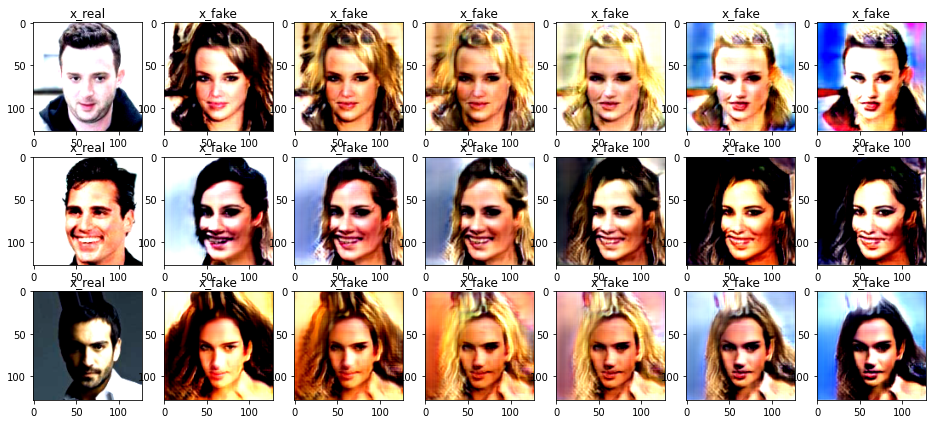

In [25]:
# 1 real image and 2 random latents (batch of 8 actually)
x_real, _, _, _, y_trg, z_trg, z_trg2 = next(iter(dataloader))
x_real = x_real.to(device)
y_trg = y_trg.to(device)
z_trg = z_trg.to(device)
z_trg2 = z_trg2.to(device)

# interpolation points between latents
point_1 = torch.lerp(z_trg, z_trg2, weight=0.2).to(device)
point_2 = torch.lerp(z_trg, z_trg2, weight=0.4).to(device)
point_3 = torch.lerp(z_trg, z_trg2, weight=0.6).to(device)
point_4 = torch.lerp(z_trg, z_trg2, weight=0.8).to(device)

plt.figure(figsize=(16, 7))

for i in range(3):
    plt.subplot(3, 7, i*7+1)
    img = denormalize(x_real[i].detach().cpu().numpy().transpose(1,2,0))
    plt.imshow(img)
    plt.title('x_real')

for i, latent in enumerate([z_trg, point_1, point_2, point_3, point_4, z_trg2]):
    # style extraction and image generation
    s_trg = nets.mapping_network(latent, y_trg)
    x_fake = nets.generator(x_real, s_trg)

    for j in range(3):
        plt.subplot(3, 7, j*7+i+2)
        img = denormalize(x_fake[j].detach().cpu().numpy().transpose(1,2,0))
        plt.imshow(img)
        plt.title('x_fake')

plt.show()

* Наблюдаем плавный переход между двумя разными стилями, перенесенными на одно исходное изображение противоположного домена

#### Ревью/комментарии решения

* _По результатам_
  * LPIPS получился 2.77, что довольно высоко, думаю модель такого размера на таких больших картинках недоучилась
  * Несмотря на LPIPS, качество получилось в целом сносное для такого размера сети и времени обучения
  * Поза/эмоция/черты головы схожи с исходным, а стиль - оттенок, черты лица мужские/женские, губы - перенесен
  * Артефакты вокруг головы часто наблюдаются, неоднозначный/непонятный фон размывается
* _По модулям_
  * Dataloader для StarGAN V2 кастомный, выдает батчи размера 8 с полным набором всего необходимо для итерации (x_real, y_org, x_ref, x_ref2, y_ref, z_trg, z_trg2)
  * Базовые блоки ResBlk, AdaIN, AdainResBlk аналогичны авторской имплементации с минимумом изменений
  * Модули Generator, MappingNetwork, StyleEncoder, Discriminator сделаны в соответствии со статьей для изображений размера 128x128 для 2 доменов и размерности стиля 64
* _По обучению_
  * Лоссы и оптимизаторы как в статье, есть регуляризация R1 и He инициализация, коэффициенты дефолтные (лямбды = 1)
  * Время обучения последней версии ~7 часов на GPU Colab'а, часть попыток сгорели из-за перезапусков
* _По улучшениям хотелось бы_
  * учить подольше и привести в порядок эксперименты (e.g. Weights & Biases) 
  * поиграть с коэффициенами при лоссах (например, больше упор на cycle-consistency loss, так как иногда недостаточно сохраняются domain invariant характеристики)
  * добавить EMA сглаживание весов
  * разобраться и добавить FAN и masks
  * попробовать облегчить модель, уменьшив кол-во и размерности слоев и добиться быстрой скорости на меньших картинках 32x32/64x64
  * совсем advance было бы интересно дистиллировать хорошо обученную модель в меньший размер для быстрого инференса, мб даже на CPU